In [56]:
import gym
import numpy as np
from PIL import Image

import matplotlib.pylab as plt
%matplotlib inline

In [57]:
env = gym.make('MontezumaRevenge-v0')

In [58]:
state = env.reset()

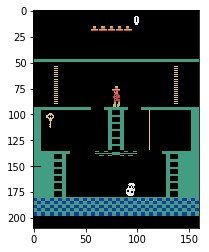

In [59]:
plt.imshow(state)

In [60]:
state.shape

(210, 160, 3)

In [61]:
image = Image.fromarray(state)

def encodeToCell(frame):
    return frame.convert('L').resize(size=(8,11))

In [62]:
cell = encodeToCell(image)

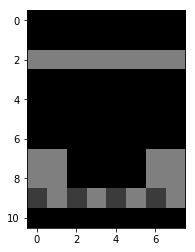

In [63]:
plt.figure(figsize=(6, 4))
plt.imshow(cell)

In [64]:
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [65]:
from tqdm import tqdm_notebook

In [66]:
def markovUniform(size, epsilon):
    cpt = np.eye(size) * (1-epsilon)
    
    resid = np.zeros_like(cpt)
    resid.fill(epsilon/(size-1))
    
    cpt += resid - np.eye(size) * (epsilon / (size - 1)) 
    
    
    for i in range(size):
        cpt[i,:] /= cpt[i,:].sum()
    return cpt

In [105]:


def encodeToCell(obs):
    palette = [ int(x) for x in np.linspace(0, 255, num=8) ]
    
    frame = Image.fromarray(obs)
    return str(list(frame.convert('L').resize(size=(8,11)).convert('P', 
                                                                   palette=palette, 
                                                                   colors=8).getdata()))

class Agent:
    def __init__(self, name, verbose=False):
        self.env = gym.make(name)
        self.env.env.ale.setFloat('repeat_action_probability', 0.)
        self.env.env.frameskip = 1
        self.env.reset()
        
        self.cells_hashes = []
        # cell_hash : [cell_hash, trajectory, state, sample_score, reward ]
        self.cells = {}
        # cell_hash : fitness
        self.fitness = {}
        
        self.n_explore = 10
        self.explore_steps = 100
        self.initial_score_for_new_cell = 10
        self.strategy = 'markov'
        self.transition_matrix = None
        
        self.initialize_archive()
        
        self.verbose = verbose
        
    
    def run(self, iterations):
        #frame = self.env.reset()
        #snapshot = self.env.env.ale.cloneSystemState()
        #initialCell = [encodeToCell(frame), [], snapshot, 1]
        for _ in tqdm_notebook(range(iterations)):
            # choose cells
            scores = np.array([ self.cells[c][3]  for c in self.cells_hashes])
            probs = scores / np.sum(scores)

            cells_to_explore = [ self.cells_hashes[i] 
                                for i in np.random.choice(range(len(self.cells_hashes)), 
                                                          size = self.n_explore, 
                                                          p = probs) ]
            # explore
            results = []
            for c in cells_to_explore:

                cell = self.cells[c]

                result = self.explore(cell)
                results.append(result)

            # update archive
            self.update_archive(results)
    
    def get_state(self):
        return self.env.env.ale.cloneSystemState()
    
    def reset_state(self, state):
        self.env.env.ale.restoreSystemState(state)
    
    def initialize_archive(self):
        frame = self.env.reset()
        cell_hash = encodeToCell(frame)
        trajectory = []
        reward = 0
        self.inital_state = self.get_state()
        
        
        self.cells_hashes.append(cell_hash)
        self.fitness[cell_hash] = 0
        self.cells[cell_hash] = [cell_hash, 
                                 trajectory, 
                                 self.inital_state, 
                                 self.initial_score_for_new_cell,
                                 reward]
    
    def choose_action(self):
        if self.strategy == 'random' :
            action = self.env.action_space.sample()
        else:
            if self.transition_matrix is None:
                self.transition_matrix = markovUniform(env.action_space.n, 0.1)
                action = self.env.action_space.sample()
            else:
                action = np.random.choice(range(self.env.action_space.n), 
                                          p=self.transition_matrix[self.last_action])
        
        self.last_action = action
        return action
    
    def explore(self, cell, render=False):
        
        new_cells = 0
        
        start_cell_hash, start_trajectory, state, _ , cell_reward = cell
        trajectory = start_trajectory.copy()
        explored_cells = [start_cell_hash]
        # return to cell (just reset for ALE game like Montezooma)
        self.env.reset()
        self.reset_state(state)
        #self.env.step(0)
        
        for i in range(self.explore_steps):
            action = self.choose_action()
            obs, reward, done, info = self.env.step(action)
            
            if self.verbose:
                if render:
                    print(action)
                    print(done)
                    print(info)
                    plt.imshow(obs)

            
            cell_hash = encodeToCell(obs)
            trajectory.append(action)
            cell_reward += reward
            
            
            if cell_hash not in explored_cells:
                explored_cells.append(cell_hash)
            
            if cell_hash in self.cells:
                # check if trajectory is better and replace
                if len(trajectory) < self.fitness[cell_hash]:
                    
                    if done:
                        if self.verbose:
                            print('done in better cell')
                            print(cell_hash)
                            pass
                    else:
                        
                        if self.verbose:
                            print('New cell: %d' % (len(trajectory) - self.fitness[cell_hash]))
                            print('hash: %s' % (cell_hash) )
                            print('='*20)
                        
                        sample_score = self.cells[cell_hash][3] + 1

                        self.cells[cell_hash] = [cell_hash, 
                                                 trajectory.copy(), 
                                                 self.get_state(),
                                                 sample_score,
                                                 cell_reward
                                                ]
                        self.fitness[cell_hash] = len(trajectory)
            else:
                # new cell
                new_cells += 1
                if done:
                    if self.verbose:
                        print('done in new cell')
                    sample_score = 0
                else:
                    sample_score = self.initial_score_for_new_cell
                    
                
                self.cells[cell_hash] = [cell_hash, 
                                         trajectory.copy(), 
                                         self.get_state(),
                                         sample_score,
                                         cell_reward]
                self.fitness[cell_hash] = len(trajectory) # reward ??
                self.cells_hashes.append(cell_hash)
            
            if done:
                break
            
            
        # reduce score of moe explored cell
        for cell_hash in  explored_cells:
            self.cells[cell_hash][3] *= 0.7
                
        self.cells[start_cell_hash][3] += new_cells
        
        
            
    def update_archive(self, results):
        pass
            

In [106]:
import imageio
#imageio.plugins.freeimage.download()

def makeGifFromCell(env_name, cell, name, init_state, skipframes=1):
    cell_hash, trajectory, state, _ , cell_reward = cell.copy()
    
    env = gym.make(env_name)
    env.env.ale.setFloat('repeat_action_probability', 0.)
    env.env.frameskip = 1
    
    env.reset()
    
    print(env.env.ale.getFloat('repeat_action_probability'))
    print(env.env.frameskip)
    env.env.ale.restoreSystemState(init_state)
    
    frames = []
    i = 0
    
    for a in trajectory:
        obs, r, done, info = env.step(a)
        
        if i % skipframes == 0:
            frames.append(obs)
        
        if done:
            print(i)
            break
        
        i += 1
        
    imageio.mimwrite('%s_%d_skip=%d' % (name, len(trajectory), skipframes), frames, format='GIF-FI', fps=30)
    env.close()

In [107]:
agent = Agent('MontezumaRevenge-v0', verbose=False)

In [ ]:
agent.run(2000)

In [116]:
len(agent.cells)

845

In [117]:
agent.fitness

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 0, 0, 0, 0, 127, 127, 127, 127, 0, 0, 0, 0, 127, 127, 59, 127, 59, 127, 59, 127, 59, 127, 0, 0, 0, 0, 0, 0, 0, 0]': 0,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 0, 0, 0, 0, 127, 127, 127, 127, 0, 0, 0, 0, 127, 127, 59, 127, 59, 127, 59, 127, 59, 127, 0, 0, 0, 0, 0, 0, 0, 0]': 9,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 0, 0, 0, 0, 127, 127, 127, 127, 0, 0, 0, 0, 127, 127, 59, 127, 59, 127, 59, 127, 59, 127, 0, 0, 0, 0, 0, 0, 0, 0]': 16,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [112]:
cell_hash_to_explore = '[0, 0, 0, 0, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 0, 236, 236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 127, 59, 127, 127, 127, 127, 59, 127, 59, 127, 59, 127, 127, 59, 127, 59, 59, 127, 59, 127, 127, 59, 127, 59, 127, 59, 127, 127, 127, 127, 59, 127, 127, 59, 127, 127, 127, 127, 59, 127, 0, 0, 0, 0, 0, 0, 0, 0]'

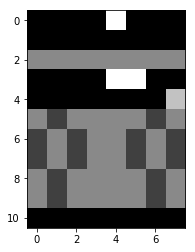

In [113]:
a = eval(cell_hash_to_explore)
plt.imshow(np.array(a).reshape(11, 8), cmap='gray')

In [114]:
cellhash = cell_hash_to_explore
cell = agent.cells[cellhash]

makeGifFromCell('MontezumaRevenge-v0', cell, 'test', agent.inital_state, skipframes=3)

0.0
1


In [69]:
cell

['[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 127, 0, 0, 0, 0, 127, 127, 127, 127, 0, 0, 0, 0, 127, 127, 59, 127, 59, 127, 59, 127, 59, 127, 0, 0, 0, 0, 0, 0, 0, 0]',
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 94082290859968,
 1.0532944642349345e-75,
 0.0]

In [118]:
for k, v in agent.cells.items():
    print(v[3], len(v[1]), v[4])

5e-324 0 0
9.688919212755983e-160 9 0.0
2.489309452037869e-88 16 0.0
8.576969174052978e-100 19 0.0
6.395622899745538e-96 20 0.0
2.306097712088536e-177 22 0.0
9.429969512655417e-94 26 0.0
1.104428709950241e-83 29 0.0
4.055169370884219e-215 32 0.0
1.1544717474136624e-111 28 0.0
3.353441460975974e-103 10 0.0
2.6278959510109415e-62 36 0.0
4.579148066659044e-72 39 0.0
5.172800924718135e-53 40 0.0
4.6415902845366425e-26 44 0.0
8.041408128609032e-171 8 0.0
1.8464651997237994e-71 52 0.0
7.827514465321156e-101 73 0.0
3.3534383163889627e-25 78 0.0
8.835429679601935e-84 72 0.0
2.3053953109271617e-60 87 0.0
9.472633233748243e-27 52 0.0
5.139646735811431e-28 18 0.0
4.221733157417464e-112 89 0.0
5.243343233836623e-87 91 0.0
3.965548785559843e-59 104 0.0
7.836422510936577e-38 107 0.0
5.86987021179227e-203 110 0.0
2.0778649625407973e-26 12 0.0
3.6155030444480934e-58 29 0.0
3.4145516489726384e-68 56 0.0
2.675784431715091e-28 81 0.0
7.983530599378103e-25 56 0.0
2.4118672940474036e-90 58 0.0
1.4932384345

In [95]:
env = gym.make('MontezumaRevenge-v0')
env.reset();

In [96]:
for a in cell[1]:
    env.step(a)
    env.render()

In [49]:
env.env.ale.restoreSystemState(cell[2])


In [55]:
env.render()

obs, r, done, info = env.step(env.action_space.sample())
print([r, done, info])

[0.0, True, {'ale.lives': 6}]


In [53]:
# agent.env.reset()
agent.env.env.ale.restoreSystemState(cell[2])

In [54]:
env = agent.env

In [1]:
cell

NameError: name 'cell' is not defined